### Structure Notebook

Return profile of stocks when they return to their original value.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from strategy import getProfit

# np.linspace(-0.5,0,100)
returnLoss = -0.10
transactionReturn = -0.002
numSamples = 10000
maxGain = 0.1 # 1/(1+returnLoss)
gains = np.linspace(0.0001, maxGain, numSamples).tolist()
profits = [getProfit(returnLoss, gain, transactionReturn) for gain in gains]

plt.plot(gains, profits);
plt.xlabel("daily gain");
plt.ylabel("profit");
plt.title("profit for different gains");
plt.ylim([min(0, min(profits)), max(profits)*1.05])


(0, 0.010652114928165972)

### Percentage Gain

### Simulating with Stock Returns


In [3]:
import yfinance as yf

tickers = "SPY AAPL TSLA AD.AS AF.PA NCLH MSFT ^AEX"
# tickers = "SPY AAPL GOOGL TBI JNJ CVS"
# tickers = "SPY CVS TBI"
tickers = 'SPY ^AEX TSLA'
tickers = 'SPY ^AEX'
df = yf.download(tickers, start="2002-01-01", end="2021-12-30")
pricesDF = df['Adj Close']
returnsDF = pricesDF.pct_change()
returnsDF = returnsDF[returnsDF.isnull().sum(1).eq(0)]
returnsDF.head(2)

[*********************100%***********************]  2 of 2 completed


,SPY,^AEX
Date,,
2002-01-03,0.011339,0.012703
2002-01-04,0.006676,-0.008514


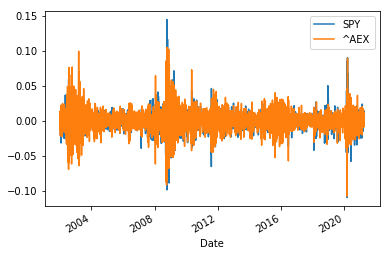

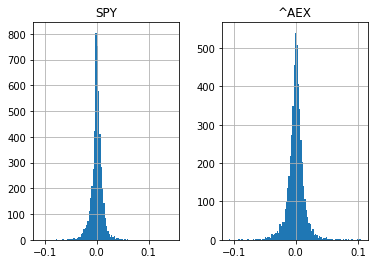

In [4]:
returnsDF.plot();
returnsDF.hist(bins=100);

C:\Program Files\Python37\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


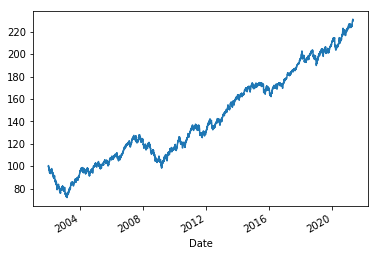

In [5]:
# value portfolio, position 
import math

tickers = 'SPY'
ticker = tickers.split()[0]
selectedTickers = tickers.split()
valuePortfolio = 100
targetRelativeVol = 0.1
targetAbsoluteVol = 100 * targetRelativeVol
tradingDaysPerYear = 250
dailyVol = targetAbsoluteVol / math.sqrt(tradingDaysPerYear)
tickerVol = returnsDF.std()[ticker]
positionSize = dailyVol/tickerVol
transactionSpread = 0.002
volWindow = 7
returnsDF['PortfolioValue'] = valuePortfolio
returnsDF['PositionSize'] = 1
returnsDF['vol'] = returnsDF[ticker].shift(1).pow(2).rolling(window=volWindow).mean().pow(0.5)

for idx in range(1, len(returnsDF)):
    oldPortfolioValue = returnsDF['PortfolioValue'].iloc[idx-1]
    # actualPositionSize = min(oldPortfolioValue, positionSize)
    actualPositionSize = min(oldPortfolioValue, dailyVol/returnsDF['vol'].iloc[idx])
    actualPositionSize = min(actualPositionSize, valuePortfolio)
    gains = returnsDF[selectedTickers].iloc[idx].mean() * actualPositionSize
    transactionCost = actualPositionSize*abs(returnsDF[selectedTickers].iloc[idx]).mean()*transactionSpread
    newPortfolioValue = oldPortfolioValue + gains - transactionCost
    returnsDF['PortfolioValue'].iloc[idx] = newPortfolioValue
    returnsDF['PositionSize'].iloc[idx] = actualPositionSize

returnsDF['PortfolioValue'].plot();
# returnsDF['PositionSize'].plot();
# returnsDF.iloc[-1]['PortfolioValue']
# ticker = '^AEX'
# (pricesDF.loc[returnsDF.index][ticker]/pricesDF.loc[returnsDF.index][ticker].iloc[1]*valuePortfolio).plot();


In [6]:
returnsDF['vol'][-1]-returnsDF[ticker].pow(2).mean(), returnsDF[ticker].pow(2).mean()

(0.005365419968979191, 0.00014698334390388069)

In [7]:
stdP = returnsDF['PortfolioValue'].diff().pow(2).mean() ** 0.5 * (tradingDaysPerYear ** 0.5)
uP = returnsDF['PortfolioValue'].diff().mean() * tradingDaysPerYear
stdP, uP, uP/stdP

(10.229386226477049, 6.575585116046125, 0.6428132607825802)

In [8]:
# ticker = '^AEX'
stdP = pricesDF[ticker].loc[returnsDF.index].diff().pow(2).mean() ** 0.5 * (tradingDaysPerYear ** 0.5)
uP = pricesDF[ticker].loc[returnsDF.index].diff().mean() * tradingDaysPerYear
stdP, uP, uP/stdP

(30.733673044426993, 18.009255955637638, 0.5859779899917722)

# Volatility

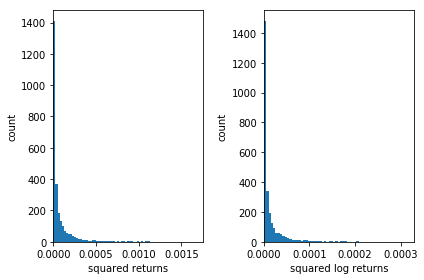

In [39]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(nrows=1, ncols=2)

ticker = "SPY"

returns = df_returns[ticker]
logReturns = np.log10(1 + returns)

squaredReturns = returns.pow(2)
squaredLogReturns = logReturns.pow(2)

ax[0] = squaredReturns.plot.hist(bins=500, ax=ax[0])
ax[0].set_xlabel('squared returns')
ax[0].set_ylabel('count')
ax[0].set_xlim([0, squaredReturns.quantile(0.99)*1.2])

ax[1] = squaredLogReturns.plot.hist(bins=500, ax=ax[1])
ax[1].set_xlabel('squared log returns')
ax[1].set_ylabel('count')
ax[1].set_xlim([0, squaredLogReturns.quantile(0.99)*1.2])
plt.tight_layout()
plt.show()


0.0014646789878306802

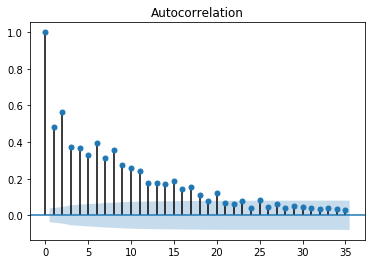

In [40]:
plot_acf(squaredReturns.to_numpy());


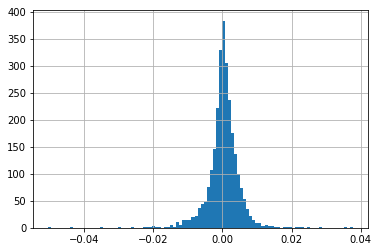

In [41]:
returns = df_returns[ticker]
logReturns = np.log10(1+returns)
logReturns.hist(bins=100);


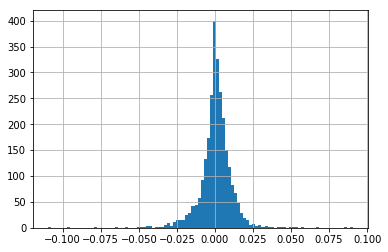

In [42]:
returns.hist(bins=100);


In [51]:
import math
import numpy as np
from arch import arch_model

ticker = 'AAPL'
squaredReturns = np.log10(1+df_returns[ticker]).pow(2)
squaredReturns = squaredReturns.clip(upper=squaredReturns.quantile(0.95))
squaredReturns = squaredReturns/squaredReturns.std()
splitDate = squaredReturns.index[math.floor(len(squaredReturns)*8/10)]

garch = arch_model(squaredReturns, vol='garch', p=10, o=0, q=10, dist='StudentsT') # Normal, 
# garch = arch_model(squaredReturns, vol='arch', p=5, o=0, q=0, dist='StudentsT') # Normal, 
garch_fitted = garch.fit(update_freq=5, last_obs=splitDate, disp='on');
garch_forecast = garch_fitted.forecast(start = squaredReturns.index[0], horizon=1)
garch_fitted.summary()


Iteration:      5,   Func. Count:    132,   Neg. LLF: 6304.304622048104
Iteration:     10,   Func. Count:    257,   Neg. LLF: 5124.117638895614
Iteration:     15,   Func. Count:    382,   Neg. LLF: 2945.3122027580143
Iteration:     20,   Func. Count:    507,   Neg. LLF: 2829.634176000684
Iteration:     25,   Func. Count:    632,   Neg. LLF: 2312.8231218654796
Iteration:     30,   Func. Count:    755,   Neg. LLF: 2137.9449417463284
Iteration:     35,   Func. Count:    877,   Neg. LLF: 2122.5848793485875
Iteration:     40,   Func. Count:    998,   Neg. LLF: 2121.770997518104
Iteration:     45,   Func. Count: 1.12e+03,   Neg. LLF: 2120.7490999443694
Iteration:     50,   Func. Count: 1.24e+03,   Neg. LLF: 2120.5948771247536
Iteration:     55,   Func. Count: 1.36e+03,   Neg. LLF: 2120.591382420741
Iteration:     60,   Func. Count: 1.48e+03,   Neg. LLF: 2120.591179190008
C:\Users\bart_\AppData\Roaming\Python\Python37\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default f

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                         AAPL   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2120.59
Distribution:      Standardized Student's t   AIC:                           4287.18
Method:                  Maximum Likelihood   BIC:                           4417.90
                                              No. Observations:                 2172
Date:                      Thu, Apr 15 2021   Df Residuals:                     2171
Time:                              10:31:23   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1984  2.093e-02      9.478  2.598e-21 [  0.157,  0.239]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6333      2.182      0.290      0.772 [ -3.643,  4.909]
alpha[1]       0.1893      0.198      0.956      0.339 [ -0.199,  0.578]
alpha[2]       0.1074      0.806      0.133      0.894 [ -1.473,  1.687]
alpha[3]       0.1431      0.727      0.197      0.844 [ -1.283,  1.569]
alpha[4]       0.0000      0.164      0.000      1.000 [ -0.322,  0.322]
alpha[5]   6.2273e-04      0.419  1.486e-03      0.999 [ -0.821,  0.822]
alpha[6]       0.0258      0.261  9.849e-02      0.922 [ -0.487,  0.538]
alpha[7]       0.0311      0.339  9.188e-02      0.927 [ -0.633,  0.695]
alpha[8]       0.1452      0.173      0.838      0.402 [ -0.195,  0.485]
alpha[9]   1.3772e-09      0.136  1.012e-08      1.000 [ -0.267,  0.267]
alpha[10]      0.0425      0.510  8.332e-02      0.934 [ -0.957,  1.042]
beta[1]        0.0000      2.870      0.000      1.000 [ -5.624,  5.624]
beta[2]    4.2362e-08      0.467  9.062e-08      1.000 [ -0.916,  0.916]
beta[3]        0.0000      2.678      0.000      1.000 [ -5.248,  5.248]
beta[4]    1.0198e-09      0.574  1.775e-09      1.000 [ -1.126,  1.126]
beta[5]        0.0000      1.568      0.000      1.000 [ -3.073,  3.073]
beta[6]        0.0000      0.678      0.000      1.000 [ -1.329,  1.329]
beta[7]        0.0000      1.032      0.000      1.000 [ -2.022,  2.022]
beta[8]    2.8437e-08      1.292  2.201e-08      1.000 [ -2.532,  2.532]
beta[9]    1.6775e-09      0.294  5.707e-09      1.000 [ -0.576,  0.576]
beta[10]       0.3149      2.267      0.139      0.890 [ -4.129,  4.759]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             2.1092  7.040e-02     29.961 3.143e-197 [  1.971,  2.247]
========================================================================

Covariance estimator: robust
"""

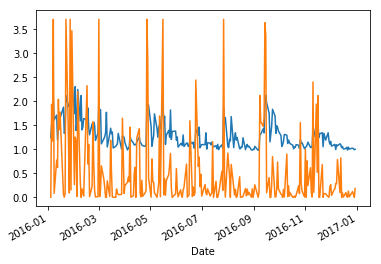

In [56]:
year = 2016
df = garch_forecast.variance['h.1']
df[df.index.year == year].pow(0.5).plot();
squaredReturns[squaredReturns.index.year == year].plot();


In [57]:
earningsDF = getEarnings(ticker)

ValueError: No tables found

In [10]:
! pip3 install yahoo_earnings_calendar


Defaulting to user installation because normal site-packages is not writeable


In [558]:
df.index.year


Int64Index([2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010,
            ...
            2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021],
           dtype='int64', name='Date', length=2715)

In [281]:
(df_returns.iloc[-1]['PortfolioValue']/valuePortfolio) ** (1/16)


1.0509380599562932

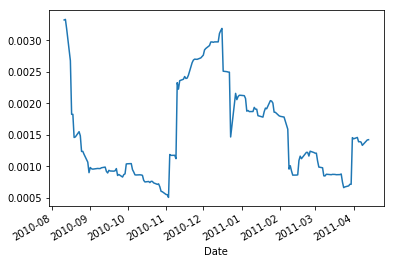

In [375]:
df_returns[ticker].pow(2).rolling(window=30).mean().head(200).plot();

In [87]:
# x = 1-(1-10**-4) ** 10000 - (10 ** -4) * 10000 * (1-10 ** -4)** 9999-10000*9999/2*((10 ** -4) ** 2) * (1-10 ** -4) ** 9998
# x

In [93]:
0.8*0.15/(0.85*0.2+0.15*0.8)

0.4137931034482758

In [92]:
import numpy as np
X = np.asarray([[1, 3/2, 3], [3/2, 0.5, 1/3], [3, 1/3, 1]])
np.linalg.eig(X)[0].sum()

2.5

In [99]:
0.5 ** 2/25
0.7 ** 2 / 49

0.009999999999999998